# Oil Company Stock Analysis
### Some questions 

### Summarizes the analysis
- 
--- 

### Draws correct coclusions or comparisons from the calculations
- 
---
---

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Dependencies and Setup
import requests
import json
import hvplot.pandas
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# yahoo finance library
import yfinance as yf


# Import the API key from geoapify
from config import geoapify_key

## 30 primary oil companies (from yahoo finance)

In [3]:
# Read 'oil_company_list.csv' and store it into Pandas DataFrames
csv_file_path_2 = 'Resources/30_oil_companies.csv'

oil_company_list_data = pd.read_csv(csv_file_path_2)

In [4]:
# Collect some data of the oil compnanies using yfinance 
ticker_symbols = oil_company_list_data["Symbol"]

companies_info = []

for ticker in ticker_symbols:
    try:
        ticker_object = yf.Ticker(ticker)
        info = ticker_object.info
        
        # Company address for mapping.
        address1 = info.get("address1")
        city = info.get("city")
        state = info.get("state")
        zip_code = info.get("zip")
        country = info.get("country")
        address = f"{address1}, {city}, {state}, {zip_code}, {country}"
        #companies_address[ticker_symbol] = address
        
        # How large is the company?
        company_name = info.get("longName")
        num_employees = info.get("fullTimeEmployees")
        market_cap = info.get("marketCap")
        enterprise_value = info.get("enterpriseValue")
        total_revenue = info.get("totalRevenue")
        gross_profits = info.get("grossProfits")
        total_debt = info.get("totalDebt")
       
        companies_info.append({
            "Company Name": company_name, 
            "Ticker": ticker, 
            "Address": address,
            "Full Time Employees": num_employees,
            "Market Capitalization (Market Cap)": market_cap,
            "Enterprise Value (EV)": enterprise_value,
            "Total Revenue": total_revenue,
            "Gross Profits": gross_profits,
            "Total Debt": total_debt
        })

    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")

# Convert companies_info to a DataFrame
companies_info_df = pd.DataFrame(companies_info)

# clean data
companies_info_df_cleaned = companies_info_df.dropna()
companies_info_df_cleaned.head()

,Company Name,Ticker,Address,Full Time Employees,Market Capitalization (Market Cap),Enterprise Value (EV),Total Revenue,Gross Profits,Total Debt
0,Exxon Mobil Corporation,XOM,"5959 Las Colinas Boulevard, Irving, TX, 75039-...",62000.0,452126474240,460750585856,367977005056,133715000000,41495998464
1,Chevron Corporation,CVX,"6001 Bollinger Canyon Road, San Ramon, CA, 945...",43846.0,306870190080,313186058240,214671998976,98886000000,21514000384
2,Shell plc,SHEL,"Shell Centre, London, None, SE1 7NA, United Ki...",91140.0,209383505920,251110932480,358589005824,97308000000,84366000128
3,TotalEnergies SE,TTE,"2, place Jean Millier, Courbevoie, None, 92078...",101279.0,151686578176,180737343488,238681997312,92261000000,56412000256
4,ConocoPhillips,COP,"925 North Eldridge Parkway, Houston, TX, 77079...",9700.0,142557167616,150705373184,68775002112,39598000000,16444000256


# the location of the companies

In [5]:
# Find latitude and longitude of company from geoapify.com

for index, company in companies_info_df_cleaned.iterrows():
    company_address = company["Address"]
    #company_address = '5959 Las Colinas Boulevard, Irving, TX, 75039-2298, United States'
    url = f"https://api.geoapify.com/v1/geocode/search?text={company_address}&apiKey={geoapify_key}"
    try:
        # Send the API request
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors (e.g., 404)

        data = response.json()
        latitude = data["features"][0]["properties"]["lat"]
        longitude =data["features"][0]["properties"]["lon"]
        #print(f"Latitude: {latitude}, Longitude: {longitude}")
        companies_info_df_cleaned.loc[index, ["Latitude", "Longitude"]] = [latitude, longitude]
    except:
        print("Company not found or error in API response.")

In [6]:
%%capture --no-display
map_plot_1 = companies_info_df_cleaned.hvplot.points(
"Longitude",
"Latitude",
geo=True,
tiles="OSM",
frame_width = 800,
frame_height = 600,
size = "Gross Profits",
scale = 0.0001,
color = "Company Name"
)
# Display the map plot
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Company Name,Gross Profits)

# 6 major companies based on gross profit (mainly among the most common companies in the United States)

In [7]:
filtered_df = companies_info_df_cleaned[
    companies_info_df_cleaned['Address'].str.contains("United States|United Kingdom")
]
# Sort the DataFrame by "Full Time Employees" in descending order
sorted_df = filtered_df.sort_values(by="Gross Profits", ascending=False)

# Select the top 6 companies
top_companies_profit = sorted_df.head(6)

In [8]:
%%capture --no-display
map_plot_2 = top_companies_profit.hvplot.points(
"Longitude",
"Latitude",
geo=True,
tiles="OSM",
frame_width = 800,
frame_height = 600,
size = "Gross Profits",
scale = 0.0002,
color = "Company Name"
)
# Display the map plot
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Company Name,Gross Profits)

# stock informations for the 6 companies

In [9]:
# using yfinance
companyList = top_companies_profit["Ticker"]

ticker_string = " ".join(companyList)
stock_data = {}

for companyName in companyList:
    # Download data for each company
    companyDataFrame = yf.download(companyName, start="2017-08-01", end="2023-08-01")
    
    # Download data for specific tickers within a date range
    data_range = yf.download(ticker_string, start="2020-01-01", end="2020-06-01")
    
    # Store the closing prices for the company in the dictionary
    stock_data[companyName] = companyDataFrame['Close'].resample('M').last()

# Convert the dictionary to a DataFrame
data = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed


## Gasoline price and oil company's stock price

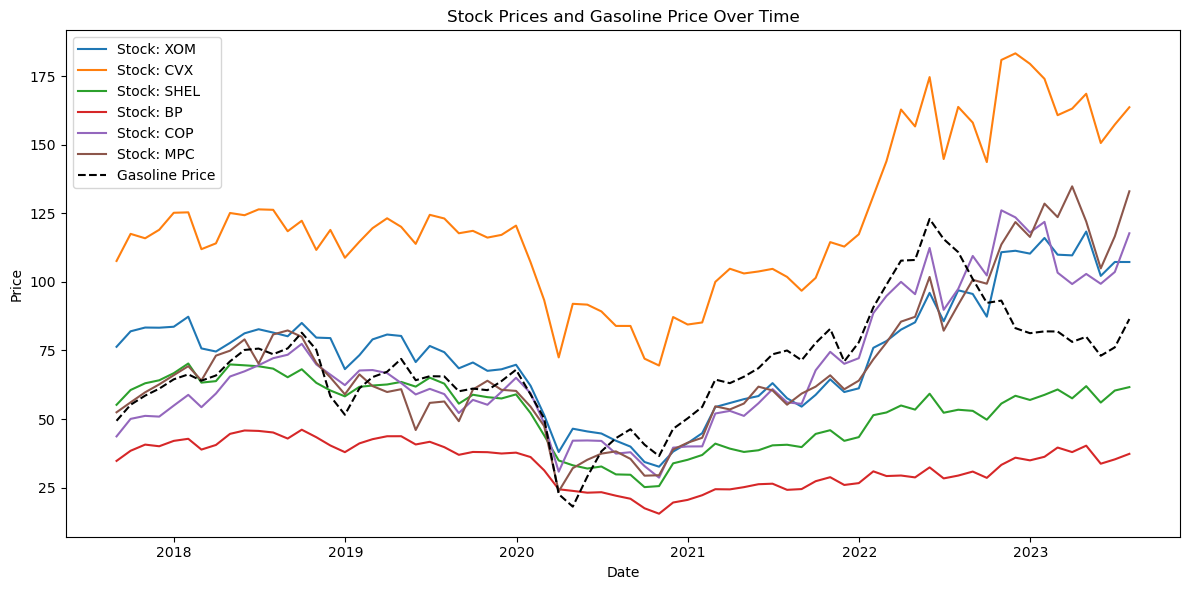

In [10]:
# oil price in the US from FRED (https://fred.stlouisfed.org/)
csv_file_path_3 = 'Resources/OPEC-ORB.csv'

Gasoline_price_data = pd.read_csv(csv_file_path_3)

# clean Gasoline data by month
Gasoline_price_data['Date'] = pd.to_datetime(Gasoline_price_data['Date'])

# Filter the data to include only the desired date range
start_date = "2017-08-01"
end_date = "2023-08-01"
filtered_data = Gasoline_price_data[(Gasoline_price_data['Date'] >= start_date) & (Gasoline_price_data['Date'] <= end_date)]

# Set 'Date' as the index
filtered_data.set_index('Date', inplace=True)

# Resample to get the last date of each month
resampled_data = filtered_data.resample('M').last()

#resampled_data.drop(resampled_data[-1], axis=1, inplace=True)
last_row_index = resampled_data.index[-1]

# Delete the last row
resampled_data.drop(last_row_index, inplace=True)

# plotting stock prices and gasoline price
plt.figure(figsize=(12, 6))

# Plot stock data for each company
for y_column in data.columns:
    y_values = data[y_column]
    plt.plot(y_values.index, y_values, label=f"Stock: {y_column}")

# Plot resampled data
plt.plot(resampled_data.index, resampled_data['Value'], label="Gasoline Price", color='black', linestyle='dashed')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Prices and Gasoline Price Over Time")
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### the line regression between Gasoline price and oil company's stock price

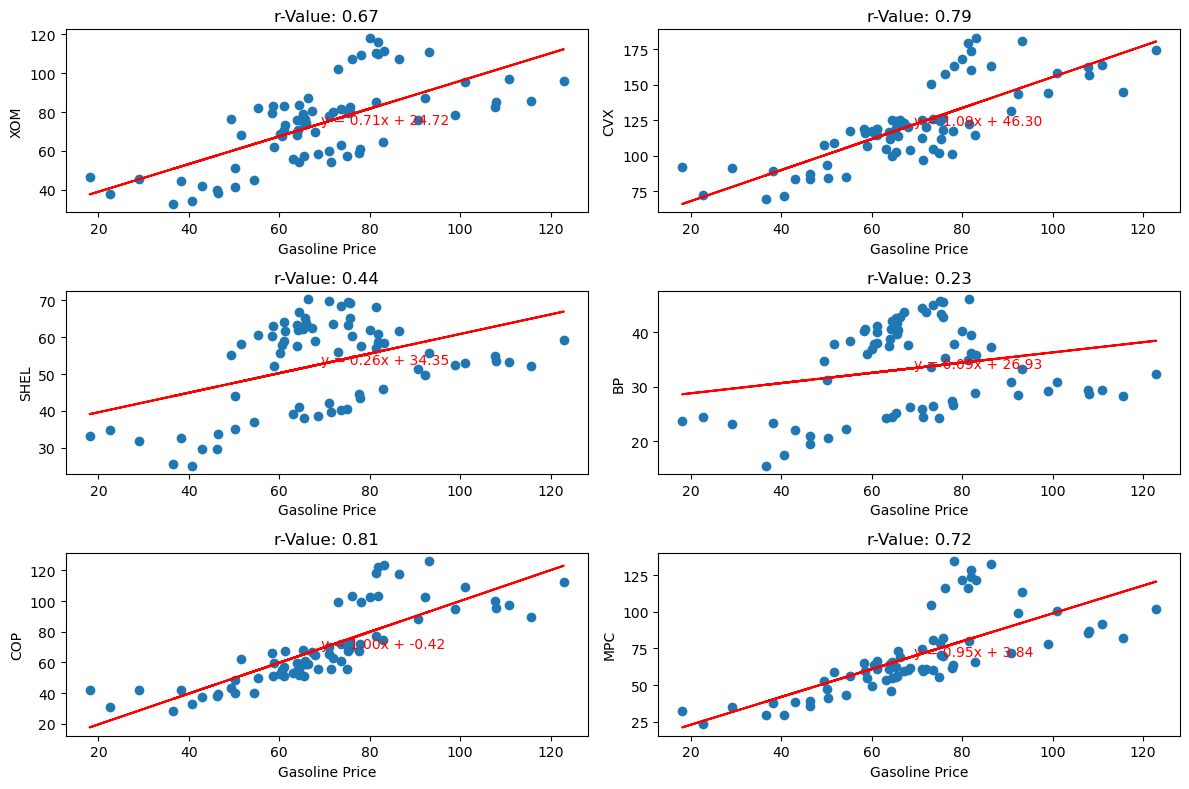

In [11]:
# Define the columns you want to use from the data DataFrame and Gasoline_price_data
x_column = "Gasoline Price"  
y_columns = companyList 

# Calculate the number of rows and columns for the subplot grid
num_rows = 3  
num_cols = 2  

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Create plots for each company's stock data
for i, y_column in enumerate(y_columns):
    # Extract x and y values
    x_values = resampled_data["Value"]
    y_values = data[y_column]
    
    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    
    # Select the appropriate subplot for the current company
    ax = axes[i]
    
    # Create scatter plot
    ax.scatter(x_values, y_values, marker='o', label='Stock Price')
    
    # Plot the regression line
    regression_line = x_values * slope + intercept
    ax.plot(x_values, regression_line, color='red', label='Regression Line')
    
    # Annotate the equation on the plot
    ax.annotate(line_eq, (x_values.mean(), y_values.mean()), fontsize=10, color="red")
    
    # Add labels and title
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'r-Value: {round(rvalue, 2)}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()